In [ ]:
import scanpy as sc
import anndata as ad
import scanpy.external as sce

import pandas as pd
import numpy as np

import statsmodels.api as sm
from statsmodels.stats.multitest import multipletests

import gseapy as gp

import matplotlib.pyplot as plt
import seaborn as sns

from sccoda.util import comp_ana as mod
from sccoda.util import cell_composition_data as dat
from sccoda.util import data_visualization as viz
import sccoda.datasets as scd

import scvi
import torch
import scipy.sparse as sp

from rich import print
import warnings
warnings.filterwarnings("ignore")
import os

outdir = "../../../write/03_sccoda/PICA0001-PICA0007"
os.makedirs(outdir, exist_ok=True)
sc.settings.figdir = "../../../figures/PICA0001-PICA0007/03_abundance_change"

### Abundance analysis (sccoda)

In [4]:
adata_age= sc.read_h5ad("../../../write/03_batch_expression/PICA0001-PICA0007/PICA0001-PICA0007_combined_annot_with_age.h5ad")

In [5]:
# Setup cell type by donor table
ct_table = (
    adata_age.obs.groupby(["pica_id", "cell_type"])
    .size()
    .unstack(fill_value=0)
)

print("ct_table shape:", ct_table.shape)
print(ct_table)

ct_table shape:
(7, 12)

cell_type  CCR6+ memory CD4 T cell  Cytotoxic CD4 T cell  \
pica_id                                                    
PICA0001                        22                    64   
PICA0002                       176                     2   
PICA0003                        18                     2   
PICA0004                        20                     6   
PICA0005                       125                     6   
PICA0006                        14                     0   
PICA0007                        68                     6   

cell_type  Cytotoxic natural killer cell  Efector memory CD8 T cell  \
pica_id                                                               
PICA0001                             446                         23   
PICA0002                             748                         75   
PICA0003                             398                         44   
PICA0004                             811                         19   
PICA0005                            2412                         36   
PICA0006                             662                         61   
PICA0007                             487                         70   

cell_type  GZMK+ memory CD8 T cell  Gamma-delta T cell  NKT cell  \
pica_id                                                            
PICA0001                        11                  96         2   
PICA0002                        91                  88        15   
PICA0003                        43                  73         6   
PICA0004                         8                  67         2   
PICA0005                        52                 513         6   
PICA0006                        24                  57         5   
PICA0007                        40                 215        19   

cell_type  Naive/Central memory CD4 T cell  Naive/Central memory CD8 T cell  \
pica_id                                                                       
PICA0001                              4436                              520   
PICA0002                              1625                              349   
PICA0003                              2203                              386   
PICA0004                              2163                              305   
PICA0005                              1060                              306   
PICA0006                              2953                              651   
PICA0007                              3192                              716   

cell_type  Regulatory T cell  Suppressed CD8 T cell  Tfh / cTfh  
pica_id                                                          
PICA0001                  74                    229         210  
PICA0002                  52                     54         176  
PICA0003                  76                     67          89  
PICA0004                  74                    111         155  
PICA0005                  16                    237         162  
PICA0006                 128                      9         109  
PICA0007                 114                    141         367

In [ ]:
# determine reference cell type
stats = pd.DataFrame({
    "nonzero_donors": (ct_table > 0).sum(0),
    "min_count": ct_table.min(0),
    "median_count": ct_table.median(0),
    "cv": (ct_table.std(0) / (ct_table.mean(0) + 1e-9))  # coefficient of variation
}).sort_values(["nonzero_donors", "median_count", "cv"], ascending=[False, False, True])

print(stats.head(8))


### Naive/Central memory CD4 T cell has all donors, high median count and lowest cv

## Creating scCODA object for larger datasets
- using Age_group instead of Age in years int

In [ ]:
meta_df = (
    adata_age.obs[["pica_id", "Age_group"]]
    .drop_duplicates()
    .set_index("pica_id")
)

meta_df

In [ ]:
# merge donor metadata into the counts table
ct_table_with_meta = ct_table.merge(meta_df, left_index=True, right_index=True)

# create scCODA data object
sccoda_data = dat.from_pandas(ct_table_with_meta, ["Age_group"])

print(sccoda_data)

In [ ]:
# run scCODA compositional analysis
model = mod.CompositionalAnalysis(
    formula="Age_group",                            
    data=sccoda_data,
    reference_cell_type="Naive/Central memory CD4 T cell"  
)
age_results = model.sample_hmc(20000, 4)

In [ ]:
summary = age_results.summary()
print(summary)

viz.plot_effects(model)
viz.plot_inclusion_probabilities(model)

## creating scCODA object for smaller datasets ( 1 batch)
- using Age in years int instead of Age_group

In [6]:
meta_df = (
    adata_age.obs[["pica_id", "Age in years int"]]
    .drop_duplicates()
    .set_index("pica_id")
)

meta_df

,Age in years int
pica_id,
PICA0007,3
PICA0002,15
PICA0001,2
PICA0003,0
PICA0006,0
PICA0004,3
PICA0005,9


In [7]:
meta_df.rename(columns={"Age in years int": "Age_in_years_int"}, inplace=True)

# merge donor metadata into the counts table
ct_table_with_meta = ct_table.merge(meta_df, left_index=True, right_index=True)

# create scCODA data object
sccoda_data = dat.from_pandas(ct_table_with_meta, ["Age_in_years_int"])

print(sccoda_data)

AnnData object with n_obs × n_vars = 7 × 12
    obs: 'Age_in_years_int'

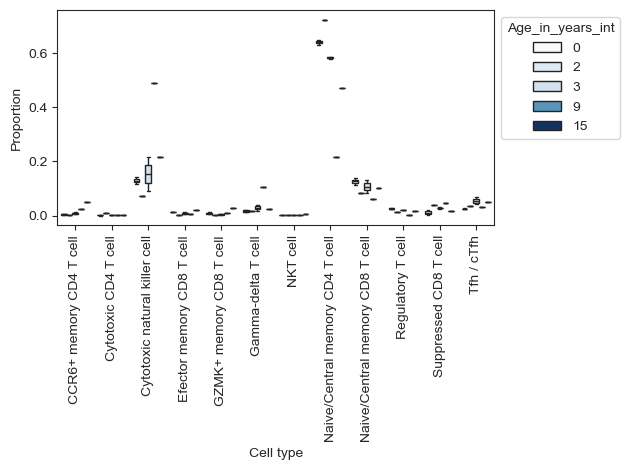

In [18]:
viz.boxplots(sccoda_data, feature_name="Age_in_years_int")
plt.show()

In [32]:
# run scCODA compositional analysis
model = mod.CompositionalAnalysis(
    formula="Age_in_years_int",                            
    data=sccoda_data,
    reference_cell_type="Naive/Central memory CD4 T cell"  
)
age_results = model.sample_hmc(20000, 4)

Zero counts encountered in data! Added a pseudocount of 0.5.


100%|██████████| 20000/20000 [00:46<00:00, 427.47it/s]


MCMC sampling finished. (50.097 sec)
Acceptance rate: 0.0%


In [52]:
age_results.summary()

Compositional Analysis summary:

Data: 7 samples, 12 cell types
Reference index: 7
Formula: Age_in_years_int

Intercepts:
                                 Final Parameter  Expected Sample
Cell Type                                                        
CCR6+ memory CD4 T cell                   -1.514        58.326883
Cytotoxic CD4 T cell                      -0.381       181.102487
Cytotoxic natural killer cell             -0.788       120.549818
Efector memory CD8 T cell                 -0.740       126.477332
GZMK+ memory CD8 T cell                   -1.538        56.943702
Gamma-delta T cell                         0.569       468.278450
NKT cell                                   1.945      1853.930200
Naive/Central memory CD4 T cell            0.769       571.956590
Naive/Central memory CD8 T cell            0.027       272.343217
Regulatory T cell                         -2.022        35.095155
Suppressed CD8 T cell                      0.617       491.304008
Tfh / cTfh          

1) Intercepts: baseline (avg) log-relative abundance of each cell type when age is 0

2) Effects: log-fold changes with age
- positve: cell type increase with age
- negative: cell type decrease with age

In [ ]:
print(age_results.credible_effects())

Covariate         Cell Type                      
Age_in_years_int  CCR6+ memory CD4 T cell             True
                  Cytotoxic CD4 T cell                True
                  Cytotoxic natural killer cell       True
                  Efector memory CD8 T cell           True
                  GZMK+ memory CD8 T cell             True
                  Gamma-delta T cell                  True
                  NKT cell                            True
                  Naive/Central memory CD4 T cell    False
                  Naive/Central memory CD8 T cell     True
                  Regulatory T cell                   True
                  Suppressed CD8 T cell               True
                  Tfh / cTfh                          True
Name: Final Parameter, dtype: bool

95% credibile interval of age effect -> TRUE: confidence that age has a real influence on cell types' proportion 
- only Naive/Central memory CD4 T cell did not show a credible difference with age, while all others do
- no need to adjust FDR

In [74]:
intercepts_df = age_results.intercept_df.reset_index()
effects_df = age_results.effect_df.reset_index()

intercepts_df.to_csv("../../../figures/PICA0001-PICA0007/03_sccoda/age_sccoda_intercepts.csv", index=False)
effects_df.to_csv("../../../figures/PICA0001-PICA0007/03_sccoda/age_sccoda_effects.csv", index=False)

In [60]:
adata_age.uns["sccoda_summary"] = str(age_results.summary())

# Save AnnData
adata_age.write_h5ad("../../../write/03_sccoda/PICA0001-PICA0007/PICA0001-PICA0007_age_sccoda.h5ad", compression="gzip")

Compositional Analysis summary:

Data: 7 samples, 12 cell types
Reference index: 7
Formula: Age_in_years_int

Intercepts:
                                 Final Parameter  Expected Sample
Cell Type                                                        
CCR6+ memory CD4 T cell                   -1.514        58.326883
Cytotoxic CD4 T cell                      -0.381       181.102487
Cytotoxic natural killer cell             -0.788       120.549818
Efector memory CD8 T cell                 -0.740       126.477332
GZMK+ memory CD8 T cell                   -1.538        56.943702
Gamma-delta T cell                         0.569       468.278450
NKT cell                                   1.945      1853.930200
Naive/Central memory CD4 T cell            0.769       571.956590
Naive/Central memory CD8 T cell            0.027       272.343217
Regulatory T cell                         -2.022        35.095155
Suppressed CD8 T cell                      0.617       491.304008
Tfh / cTfh          